In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
from scipy import stats
from pingouin import sphericity
import numpy as np

In [148]:
df = pd.read_csv('./DataSheet_Thesis.csv')

In [149]:
# Load and clean the data
def load_and_clean_data(filepath):
    """
    Load the CSV file and perform initial cleaning:
    - Remove rows with missing metric values
    - Convert numeric columns to appropriate types
    - Standardize column names
    """
    df = pd.read_csv(filepath)

    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Select only relevant columns for analysis
    metrics = ['ai_model', 'problems', 'loc', 'cyclomatic', 'halstead', 'maintainability', 'correctnes', 'timecomplexity', 'spacecomplexity', 'solution']
    df = df[metrics]

    # Drop rows where any metric is missing
    df = df.dropna()

    # Convert numeric columns (some might be read as objects)
    numeric_cols = ['loc', 'cyclomatic', 'halstead', 'maintainability']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    return df

In [150]:
# Check ANOVA assumptions
def check_assumptions(data, metric, group_col='ai_model'):
    """
    Check the three main ANOVA assumptions:
    1. Normality (Shapiro-Wilk test)
    2. Homogeneity of variance (Levene's test)
    3. Sphericity (for repeated measures)
    """
    print(f"\n=== Checking Assumptions for {metric} ===")

    # 1. Normality (check residuals)
    model = ols(f'{metric} ~ C({group_col})', data=data).fit()
    _, p_norm = stats.shapiro(model.resid)
    print(f"Normality (Shapiro-Wilk) p-value: {p_norm:.4f}")
    print("-> Assumption met" if p_norm > 0.05 else "-> WARNING: Normality violated")

    # 2. Homogeneity of variance
    groups = [data[data[group_col] == group][metric] for group in data[group_col].unique()]
    _, p_homog = stats.levene(*groups)
    print(f"Homogeneity (Levene's) p-value: {p_homog:.4f}")
    print("-> Assumption met" if p_homog > 0.05 else "-> WARNING: Variance not homogeneous")

    # 3. Sphericity (only needed for repeated measures)
    if 'problems' in data.columns:
        try:
            spher_test = sphericity(data, dv=metric, within='problems', subject='ai_model')
            print(f"Sphericity (Mauchly's) p-value: {spher_test[1]:.4f}")
            print("-> Assumption met" if spher_test[1] > 0.05 else "-> WARNING: Sphericity violated")
        except:
            print("Could not calculate sphericity - may not be applicable")

    return p_norm > 0.05 and p_homog > 0.05

In [151]:
# Perform one-way ANOVA
def one_way_anova(data, metric, group_col='ai_model'):
    """
    Perform one-way ANOVA for a given metric across groups.
    Includes assumption checking and post-hoc tests if significant.
    """

    # Check assumptions first
    assumptions_met = check_assumptions(data, metric, group_col)

    # Perform ANOVA
    model = ols(f'{metric} ~ C({group_col})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\n=== One-Way ANOVA Results for {metric} ===")
    print("\nANOVA Table-----:")
    print(anova_table)

    # Calculate effect size (eta squared)
    eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
    print(f"\nEffect Size (η²): {eta_sq:.3f}")

    # If significant, perform post-hoc tests
    if anova_table['PR(>F)'][0] < 0.05:
        print("\nSignificant difference found - running post-hoc Tukey HSD...")
        tukey = pairwise_tukeyhsd(data[metric], data[group_col])
        print(tukey.summary())

        # Visualize group differences
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_col, y=metric, data=data)
        plt.title(f'Distribution of {metric} by {group_col}')
        plt.savefig(f'distibution_{metric}_by_ai.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\nNo significant differences found between groups.")

    return anova_table

In [152]:
# Perform two-way ANOVA (AI Model × Problem)
def two_way_anova(data, metric):
    """
    Perform two-way ANOVA to examine:
    - Main effect of AI Model
    - Main effect of Problem
    - Interaction effect between AI Model and Problem
    """
    print(f"\n=== Two-Way ANOVA Results for {metric} ===")

    # Fit the model
    model = ols(f'{metric} ~ C(ai_model) + C(problems) + C(ai_model):C(problems)', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA Table:")
    print(anova_table)

    # Calculate effect sizes
    total_ss = anova_table['sum_sq'].sum()
    for effect in anova_table.index:
        eta_sq = anova_table.loc[effect, 'sum_sq'] / total_ss
        print(f"\nEffect Size for {effect} (η²): {eta_sq:.3f}")

    return anova_table

In [153]:
# Load and clean data
df = load_and_clean_data('./DataSheet_Thesis.csv')

# Analyze each metric
metrics = ['loc', 'cyclomatic', 'halstead', 'maintainability']
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: LOC")
print(f"{'='*50}")
one_way_anova(df, 'loc')



ANALYZING METRIC: LOC

=== Checking Assumptions for loc ===
Normality (Shapiro-Wilk) p-value: 0.0000
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.0949
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0450
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for loc ===

ANOVA Table-----:
                  sum_sq     df         F    PR(>F)
C(ai_model)   227.401316    3.0  1.014407  0.389249
Residual     8219.625000  110.0       NaN       NaN

Effect Size (η²): 0.027

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),227.401316,3.0,1.014407,0.389249
Residual,8219.625000,110.0,NaN,NaN


In [154]:
from scipy.stats import kruskal
# For Normality Violation:
# Use Non-Parametric Alternative:

groups = [df[df['ai_model']==model]['loc'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 1.346, p = 0.718


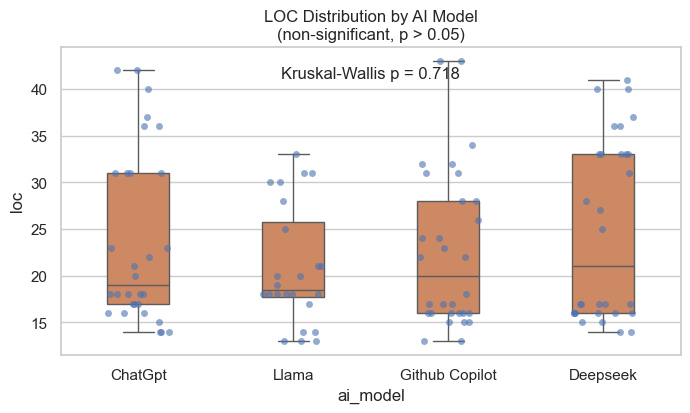

In [155]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='loc', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='loc', data=df, showfliers=False, width=0.4)
plt.title("LOC Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.5, 0.9, "Kruskal-Wallis p = 0.718", ha='center', transform=plt.gca().transAxes)
plt.show()

In [156]:
two_way_anova(df, 'loc')


=== Two-Way ANOVA Results for loc ===

ANOVA Table:
                              sum_sq    df           F        PR(>F)
C(ai_model)                87.529517   3.0    4.390379  6.248291e-03
C(problems)              7167.533929   5.0  215.709097  1.658998e-48
C(ai_model):C(problems)   453.991071  15.0    4.554333  2.362967e-06
Residual                  598.100000  90.0         NaN           NaN

Effect Size for C(ai_model) (η²): 0.011

Effect Size for C(problems) (η²): 0.863

Effect Size for C(ai_model):C(problems) (η²): 0.055

Effect Size for Residual (η²): 0.072


,sum_sq,df,F,PR(>F)
C(ai_model),87.529517,3.0,4.390379,6.248291e-03
C(problems),7167.533929,5.0,215.709097,1.658998e-48
C(ai_model):C(problems),453.991071,15.0,4.554333,2.362967e-06
Residual,598.100000,90.0,NaN,NaN


In [157]:
from scipy.stats import f

# Given F-values and degrees of freedom
anova_values = {
    "ai_model": {"F": 4.390, "df1": 3, "df2": 90},
    "problems": {"F": 215.709, "df1": 5, "df2": 90},
    "interaction": {"F": 4.554, "df1": 15, "df2": 90},
}

# Calculate p-values
p_values = {
    name: 1 - f.cdf(values["F"], values["df1"], values["df2"])
    for name, values in anova_values.items()
}

for factor, p in p_values.items():
    print(f"{factor}: p-value = {p:.4f}")

ai_model: p-value = 0.0063
problems: p-value = 0.0000
interaction: p-value = 0.0000


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1294331742.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


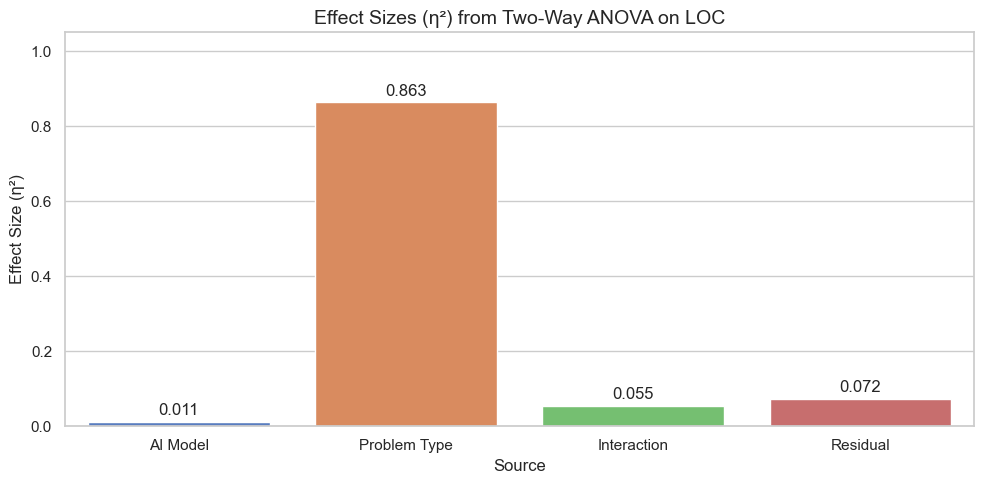

In [158]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'F-value': [4.390, 215.709, 4.554, None],
    'p-value': [0.0063, 0.0000, 0.0000, None],
    'Effect Size (η²)': [0.011, 0.863, 0.055, 0.072]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on LOC", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [159]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"LOC Range: {subset['loc'].min()}-{subset['loc'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['loc'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['loc'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
LOC Range: 16.0-19.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
       ChatGpt       Deepseek     -1.8 0.0005 -2.7911 -0.8089   True
       ChatGpt Github Copilot     -1.6 0.0015 -2.5911 -0.6089   True
       ChatGpt          Llama      0.2 0.9374 -0.7911  1.1911  False
      Deepseek Github Copilot      0.2 0.9374 -0.7911  1.1911  False
      Deepseek          Llama      2.0 0.0002  1.0089  2.9911   True
Github Copilot          Llama      1.8 0.0005  0.8089  2.7911   True
--------------------------------------------------------------------

=== Problem: FROG_POSITION ===
LOC Range: 17.0-33.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------

In [160]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Cyclomatic")
print(f"{'='*50}")
one_way_anova(df, 'cyclomatic')


ANALYZING METRIC: Cyclomatic

=== Checking Assumptions for cyclomatic ===
Normality (Shapiro-Wilk) p-value: 0.0007
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.7603
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0976
-> Assumption met

=== One-Way ANOVA Results for cyclomatic ===

ANOVA Table-----:
                  sum_sq     df         F   PR(>F)
C(ai_model)    15.878509    3.0  0.246263  0.86384
Residual     2364.191667  110.0       NaN      NaN

Effect Size (η²): 0.007

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),15.878509,3.0,0.246263,0.86384
Residual,2364.191667,110.0,NaN,NaN


In [161]:
from scipy.stats import kruskal
# For Normality Violation:
# Use Non-Parametric Alternative:

groups = [df[df['ai_model']==model]['cyclomatic'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 0.625, p = 0.891


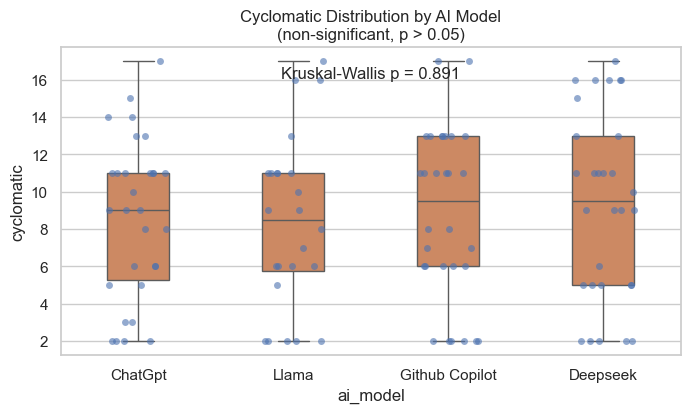

In [162]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='cyclomatic', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='cyclomatic', data=df, showfliers=False, width=0.4)
plt.title("Cyclomatic Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.5, 0.9, "Kruskal-Wallis p = 0.891", ha='center', transform=plt.gca().transAxes)
plt.show()

In [163]:
two_way_anova(df, 'cyclomatic')  


=== Two-Way ANOVA Results for cyclomatic ===

ANOVA Table:
                              sum_sq    df           F        PR(>F)
C(ai_model)                14.137255   3.0    1.785007  1.556839e-01
C(problems)              2014.423039   5.0  152.607806  2.240598e-42
C(ai_model):C(problems)   112.168627  15.0    2.832541  1.184239e-03
Residual                  237.600000  90.0         NaN           NaN

Effect Size for C(ai_model) (η²): 0.006

Effect Size for C(problems) (η²): 0.847

Effect Size for C(ai_model):C(problems) (η²): 0.047

Effect Size for Residual (η²): 0.100


,sum_sq,df,F,PR(>F)
C(ai_model),14.137255,3.0,1.785007,1.556839e-01
C(problems),2014.423039,5.0,152.607806,2.240598e-42
C(ai_model):C(problems),112.168627,15.0,2.832541,1.184239e-03
Residual,237.600000,90.0,NaN,NaN


In [164]:
from scipy.stats import f

# Given F-values and degrees of freedom
anova_values = {
    "ai_model": {"F": 1.785, "df1": 3, "df2": 90},
    "problems": {"F": 152.607, "df1": 5, "df2": 90},
    "interaction": {"F": 2.832, "df1": 15, "df2": 90},
}

# Calculate p-values
p_values = {
    name: 1 - f.cdf(values["F"], values["df1"], values["df2"])
    for name, values in anova_values.items()
}

for factor, p in p_values.items():
    print(f"{factor}: p-value = {p:.4f}")

ai_model: p-value = 0.1557
problems: p-value = 0.0000
interaction: p-value = 0.0012


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1475871054.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


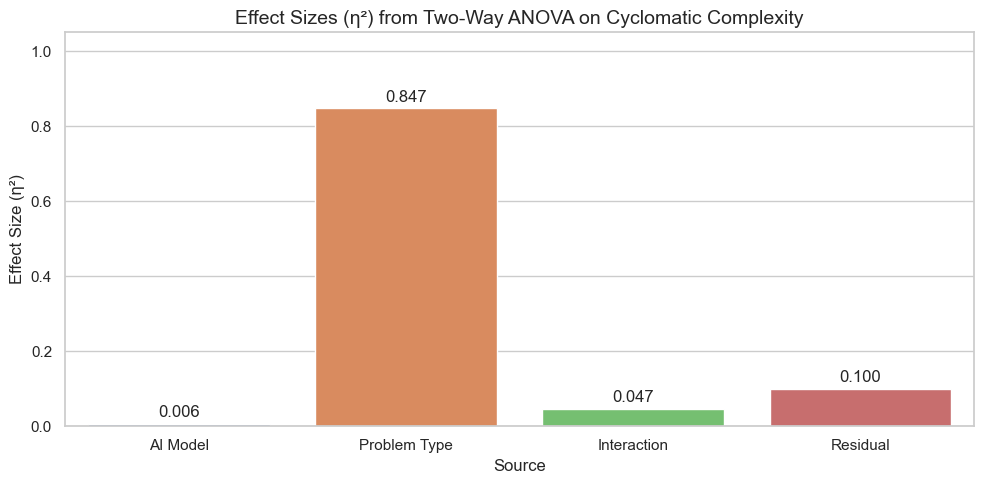

In [165]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.006, 0.847, 0.047, 0.100],
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Cyclomatic Complexity", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [166]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Cyclomatic Range: {subset['cyclomatic'].min()}-{subset['cyclomatic'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['cyclomatic'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['cyclomatic'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Cyclomatic Range: 2.0-6.0
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower  upper  reject
------------------------------------------------------------------
       ChatGpt       Deepseek     -0.8 0.509 -2.4184 0.8184  False
       ChatGpt Github Copilot     -0.8 0.509 -2.4184 0.8184  False
       ChatGpt          Llama     -0.8 0.509 -2.4184 0.8184  False
      Deepseek Github Copilot      0.0   1.0 -1.6184 1.6184  False
      Deepseek          Llama      0.0   1.0 -1.6184 1.6184  False
Github Copilot          Llama      0.0   1.0 -1.6184 1.6184  False
------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Cyclomatic Range: 3.0-17.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
    

c:\Users\rgont\OneDrive\Documents\Master_Thesis\Solutions\myenv\Lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1300: RuntimeWarning: invalid value encountered in divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


In [167]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Halstead")
print(f"{'='*50}")
one_way_anova(df, 'halstead')


ANALYZING METRIC: Halstead

=== Checking Assumptions for halstead ===
Normality (Shapiro-Wilk) p-value: 0.0000
-> WARNING: Normality violated
Homogeneity (Levene's) p-value: 0.7298
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0000
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for halstead ===

ANOVA Table-----:
                   sum_sq     df         F    PR(>F)
C(ai_model)  5.682648e+06    3.0  0.377981  0.769056
Residual     5.512543e+08  110.0       NaN       NaN

Effect Size (η²): 0.010

No significant differences found between groups.


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


,sum_sq,df,F,PR(>F)
C(ai_model),5.682648e+06,3.0,0.377981,0.769056
Residual,5.512543e+08,110.0,NaN,NaN


In [168]:

groups = [df[df['ai_model']==model]['halstead'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 1.937, p = 0.586


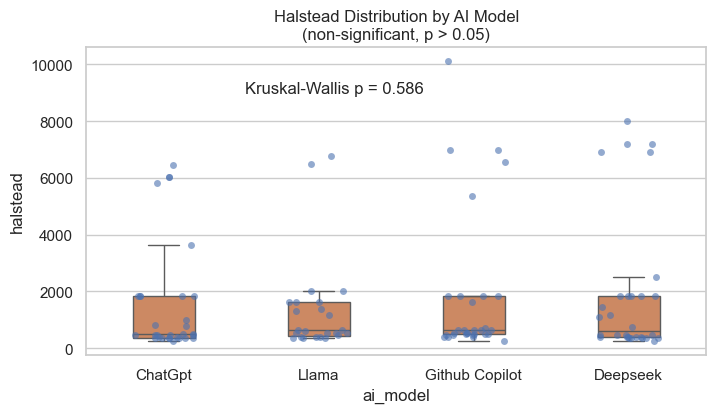

In [169]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='halstead', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='halstead', data=df, showfliers=False, width=0.4)
plt.title("Halstead Distribution by AI Model\n(non-significant, p > 0.05)")
plt.text(0.4, 0.85, "Kruskal-Wallis p = 0.586", ha='center', transform=plt.gca().transAxes)
plt.show()

In [170]:
two_way_anova(df, 'halstead')  


=== Two-Way ANOVA Results for halstead ===

ANOVA Table:
                               sum_sq    df           F        PR(>F)
C(ai_model)              2.526738e+06   3.0    3.209973  2.675981e-02
C(problems)              5.192675e+08   5.0  395.806987  1.194122e-59
C(ai_model):C(problems)  8.372200e+06  15.0    2.127212  1.513447e-02
Residual                 2.361458e+07  90.0         NaN           NaN

Effect Size for C(ai_model) (η²): 0.005

Effect Size for C(problems) (η²): 0.938

Effect Size for C(ai_model):C(problems) (η²): 0.015

Effect Size for Residual (η²): 0.043


,sum_sq,df,F,PR(>F)
C(ai_model),2.526738e+06,3.0,3.209973,2.675981e-02
C(problems),5.192675e+08,5.0,395.806987,1.194122e-59
C(ai_model):C(problems),8.372200e+06,15.0,2.127212,1.513447e-02
Residual,2.361458e+07,90.0,NaN,NaN


In [171]:
from scipy.stats import f

# Given F-values and degrees of freedom
anova_values = {
    "ai_model": {"F": 3.209, "df1": 3, "df2": 90},
    "problems": {"F": 395.806, "df1": 5, "df2": 90},
    "interaction": {"F": 2.127, "df1": 15, "df2": 90},
}

# Calculate p-values
p_values = {
    name: 1 - f.cdf(values["F"], values["df1"], values["df2"])
    for name, values in anova_values.items()
}

for factor, p in p_values.items():
    print(f"{factor}: p-value = {p:.4f}")

ai_model: p-value = 0.0268
problems: p-value = 0.0000
interaction: p-value = 0.0151


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\3690961971.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


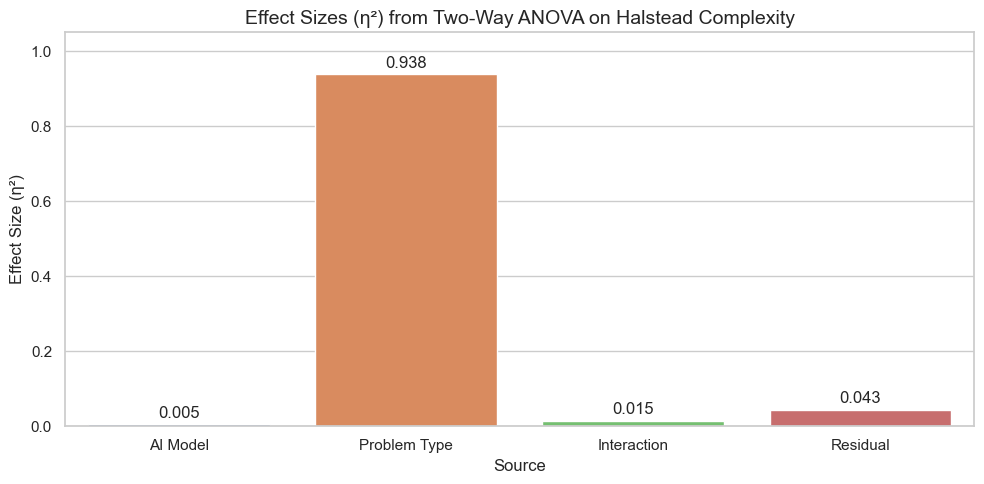

In [172]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.005, 0.938, 0.015, 0.043]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Halstead Complexity", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [173]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Halstead Range: {subset['halstead'].min()}-{subset['halstead'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['halstead'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['halstead'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Halstead Range: 349.09-506.64
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1         group2     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------
       ChatGpt       Deepseek    40.63 0.0867   -4.6373  85.8973  False
       ChatGpt Github Copilot   148.38    0.0  103.1127 193.6473   True
       ChatGpt          Llama   38.592 0.1094   -6.6753  83.8593  False
      Deepseek Github Copilot   107.75    0.0   62.4827 153.0173   True
      Deepseek          Llama   -2.038 0.9992  -47.3053  43.2293  False
Github Copilot          Llama -109.788    0.0 -155.0553 -64.5207   True
-----------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Halstead Range: 253.94-1441.46
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1         group2     meandiff p-adj    lower     upper   reject
-------


ANALYZING METRIC: Maintainability

=== Checking Assumptions for maintainability ===
Normality (Shapiro-Wilk) p-value: 0.0906
-> Assumption met
Homogeneity (Levene's) p-value: 0.3240
-> Assumption met
Sphericity (Mauchly's) p-value: 0.0028
-> WARNING: Sphericity violated

=== One-Way ANOVA Results for maintainability ===

ANOVA Table-----:
                   sum_sq     df         F    PR(>F)
C(ai_model)   2625.661479    3.0  7.588768  0.000117
Residual     12686.414433  110.0       NaN       NaN

Effect Size (η²): 0.171

Significant difference found - running post-hoc Tukey HSD...


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1064116566.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
       ChatGpt       Deepseek   -6.523 0.0926 -13.7567  0.7107  False
       ChatGpt Github Copilot  -5.6873 0.1759  -12.921  1.5463  False
       ChatGpt          Llama   5.8637 0.1966  -1.8088 13.5361  False
      Deepseek Github Copilot   0.8357 0.9904   -6.398  8.0693  False
      Deepseek          Llama  12.3867 0.0003   4.7142 20.0591   True
Github Copilot          Llama   11.551 0.0009   3.8785 19.2235   True
---------------------------------------------------------------------


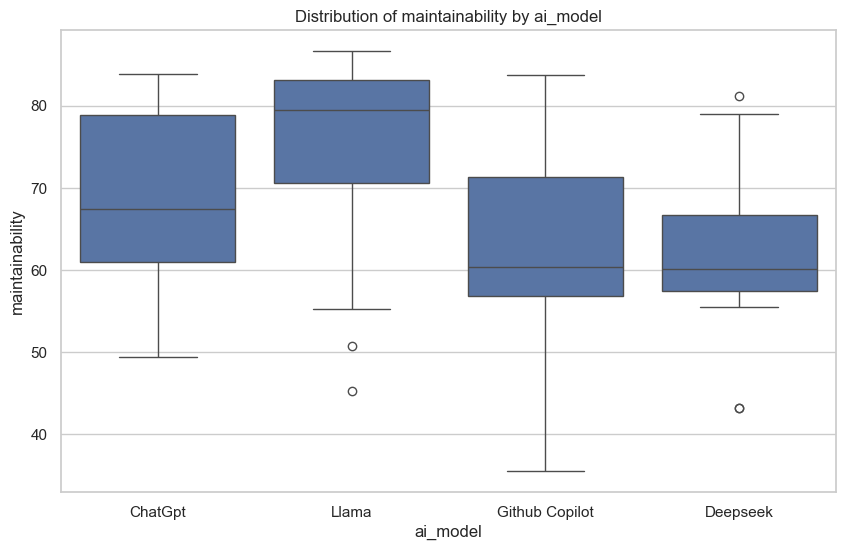

,sum_sq,df,F,PR(>F)
C(ai_model),2625.661479,3.0,7.588768,0.000117
Residual,12686.414433,110.0,NaN,NaN


In [174]:
# One-way ANOVA (AI Model effect)
print(f"\n{'='*50}")
print(f"ANALYZING METRIC: Maintainability")
print(f"{'='*50}")
one_way_anova(df, 'maintainability')

In [175]:
groups = [df[df['ai_model']==model]['maintainability'] 
          for model in df['ai_model'].unique()]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis H = {h_stat:.3f}, p = {p_val:.3f}")

Kruskal-Wallis H = 17.934, p = 0.000


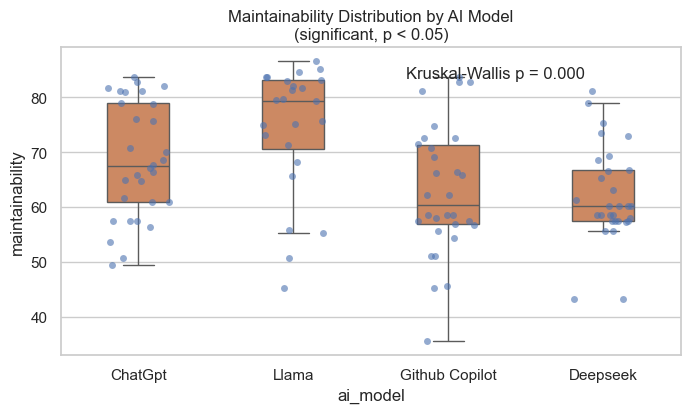

In [176]:
plt.figure(figsize=(8,4))
sns.stripplot(x='ai_model', y='maintainability', data=df, jitter=0.2, alpha=0.6)
sns.boxplot(x='ai_model', y='maintainability', data=df, showfliers=False, width=0.4)
plt.title("Maintainability Distribution by AI Model\n(significant, p < 0.05)")
plt.text(0.7, 0.9, "Kruskal-Wallis p = 0.000", ha='center', transform=plt.gca().transAxes)
plt.show()

In [177]:
two_way_anova(df, 'maintainability')  


=== Two-Way ANOVA Results for maintainability ===

ANOVA Table:
                              sum_sq    df          F        PR(>F)
C(ai_model)              2378.495133   3.0  11.189524  2.611369e-06
C(problems)              4412.582512   5.0  12.455279  3.422105e-09
C(ai_model):C(problems)  1896.898231  15.0   1.784775  4.903738e-02
Residual                 6376.933690  90.0        NaN           NaN

Effect Size for C(ai_model) (η²): 0.158

Effect Size for C(problems) (η²): 0.293

Effect Size for C(ai_model):C(problems) (η²): 0.126

Effect Size for Residual (η²): 0.423


,sum_sq,df,F,PR(>F)
C(ai_model),2378.495133,3.0,11.189524,2.611369e-06
C(problems),4412.582512,5.0,12.455279,3.422105e-09
C(ai_model):C(problems),1896.898231,15.0,1.784775,4.903738e-02
Residual,6376.933690,90.0,NaN,NaN


In [178]:
from scipy.stats import f

# Given F-values and degrees of freedom
anova_values = {
    "ai_model": {"F": 11.189, "df1": 3, "df2": 90},
    "problems": {"F": 12.455, "df1": 5, "df2": 90},
    "interaction": {"F": 1.784, "df1": 15, "df2": 90},
}

# Calculate p-values
p_values = {
    name: 1 - f.cdf(values["F"], values["df1"], values["df2"])
    for name, values in anova_values.items()
}

for factor, p in p_values.items():
    print(f"{factor}: p-value = {p:.4f}")

ai_model: p-value = 0.0000
problems: p-value = 0.0000
interaction: p-value = 0.0492


C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\2256928193.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)


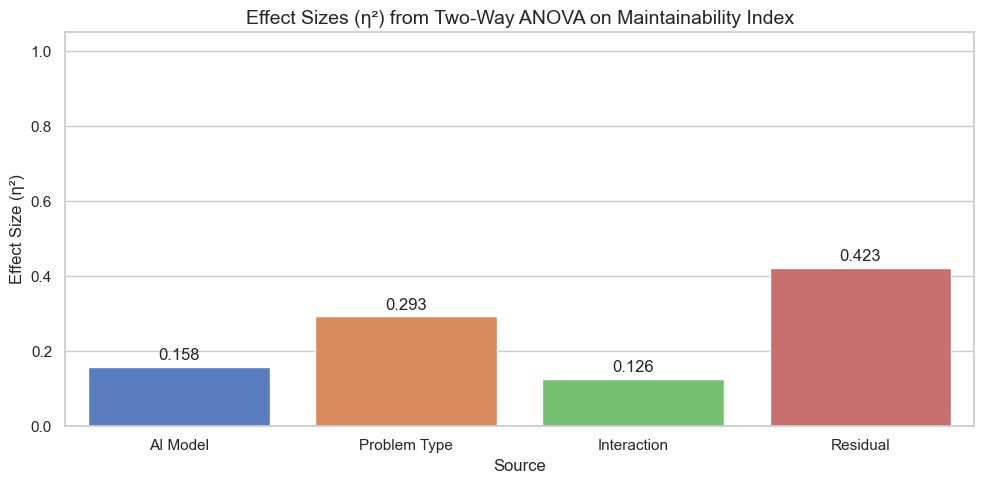

In [179]:
# Data preparation for ANOVA table
anova_data = pd.DataFrame({
    'Source': ['AI Model', 'Problem Type', 'Interaction', 'Residual'],
    'Effect Size (η²)': [0.158, 0.293, 0.126, 0.423]
})

# Set plot style
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))

# Barplot of Effect Sizes
sns.barplot(x='Source', y='Effect Size (η²)', data=anova_data, palette="muted", ax=ax)

# Add values on bars
for i, row in anova_data.iterrows():
    if row['Effect Size (η²)'] is not None:
        ax.text(i, row['Effect Size (η²)'] + 0.01, f"{row['Effect Size (η²)']:.3f}", ha='center', va='bottom')

# Set plot details
ax.set_title("Effect Sizes (η²) from Two-Way ANOVA on Maintainability Index", fontsize=14)
ax.set_ylabel("Effect Size (η²)")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [180]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Compare models within each problem
for problem in sorted(df['problems'].unique()):
    subset = df[df['problems'] == problem]
    print(f"\n=== Problem: {problem.upper()} ===")
    print(f"Maintainability Range: {subset['maintainability'].min()}-{subset['maintainability'].max()}")
    
    # Tukey HSD if >2 models
    if len(subset['ai_model'].unique()) > 2:
        tukey = pairwise_tukeyhsd(subset['maintainability'], subset['ai_model'])
        print(tukey.summary())
    else:
        # t-test for 2 models
        from scipy.stats import ttest_ind
        groups = [subset[subset['ai_model']==m]['maintainability'] 
                 for m in subset['ai_model'].unique()]
        t, p = ttest_ind(*groups)
        print(f"t-test: t = {t:.2f}, p = {p:.3f}")


=== Problem: COMBINATIONSUM2 ===
Maintainability Range: 57.96-86.64
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
       ChatGpt       Deepseek   -13.47 0.0145 -24.5149 -2.4251   True
       ChatGpt Github Copilot  -13.778 0.0123 -24.8229 -2.7331   True
       ChatGpt          Llama    6.406 0.3757  -4.6389 17.4509  False
      Deepseek Github Copilot   -0.308 0.9998 -11.3529 10.7369  False
      Deepseek          Llama   19.876 0.0005   8.8311 30.9209   True
Github Copilot          Llama   20.184 0.0004   9.1391 31.2289   True
---------------------------------------------------------------------

=== Problem: FROG_POSITION ===
Maintainability Range: 57.46-82.16
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
------------------------

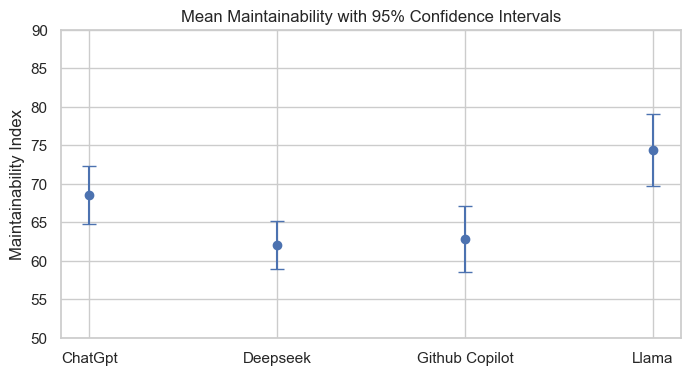

In [181]:
import matplotlib.pyplot as plt
import numpy as np

models = ['ChatGpt', 'Deepseek', 'Github Copilot', 'Llama']
means = [df[df['ai_model']==m]['maintainability'].mean() for m in models]
cis = [1.96*df[df['ai_model']==m]['maintainability'].std()/np.sqrt(df[df['ai_model']==m].shape[0]) for m in models]

plt.figure(figsize=(8,4))
plt.errorbar(models, means, yerr=cis, fmt='o', capsize=5)
plt.title("Mean Maintainability with 95% Confidence Intervals")
plt.ylabel("Maintainability Index")
plt.ylim(50,90)
plt.savefig('mean_maintainability.png', dpi=300, bbox_inches='tight')

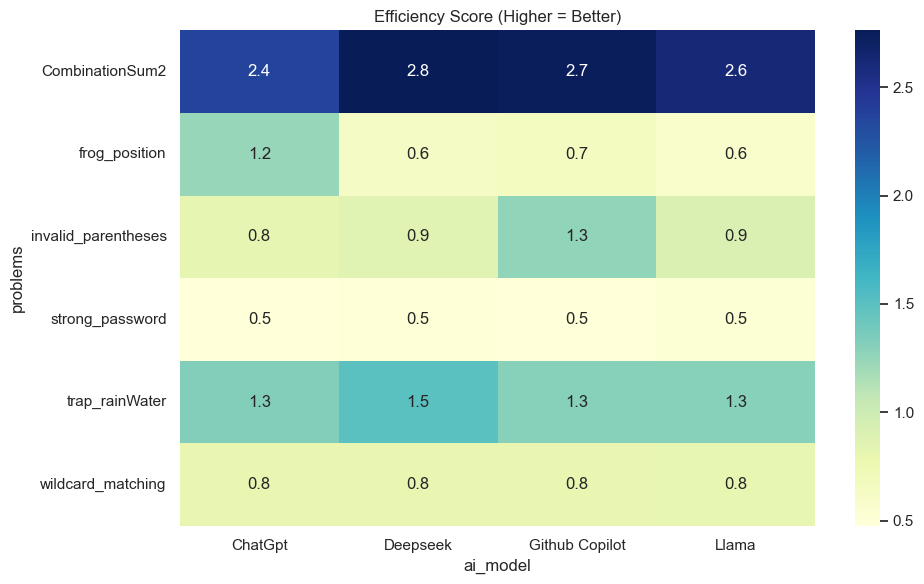

In [182]:
df['efficiency_score'] = (df['correctnes']*100) / (df['loc'] + df['cyclomatic']*10)

plt.figure(figsize=(10,6))
sns.heatmap(df.pivot_table(index='problems', columns='ai_model', values='efficiency_score'), annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Efficiency Score (Higher = Better)')
plt.savefig('efficiency_score.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

In [183]:
problem_analysis = df.groupby(['problems','ai_model']).agg({
    'loc': 'mean',
    'maintainability': 'mean',
    'correctnes': 'mean'
}).reset_index()

for problem in df['problems'].unique():
    print(f"\n🏆 {problem.upper()} LEADERBOARD:")
    display(problem_analysis[problem_analysis['problems']==problem]
            .sort_values('maintainability', ascending=False)
            .style.background_gradient(cmap='Blues'))


🏆 COMBINATIONSUM2 LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
3,CombinationSum2,Llama,18.200000,81.416000,1.000000
0,CombinationSum2,ChatGpt,18.000000,75.010000,1.000000
1,CombinationSum2,Deepseek,16.200000,61.540000,1.000000
2,CombinationSum2,Github Copilot,16.400000,61.232000,1.000000



🏆 FROG_POSITION LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
4,frog_position,ChatGpt,21.200000,72.752000,1.000000
7,frog_position,Llama,26.500000,71.960000,1.000000
5,frog_position,Deepseek,28.800000,68.814000,1.000000
6,frog_position,Github Copilot,26.000000,67.644000,1.000000



🏆 INVALID_PARENTHESES LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
11,invalid_parentheses,Llama,26.400000,71.534000,1.000000
9,invalid_parentheses,Deepseek,33.600000,60.732000,1.000000
10,invalid_parentheses,Github Copilot,25.800000,57.680000,1.000000
8,invalid_parentheses,ChatGpt,32.000000,57.414000,1.000000



🏆 STRONG_PASSWORD LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
12,strong_password,ChatGpt,39.400000,65.434000,0.866667
15,strong_password,Llama,31.000000,55.485000,1.000000
13,strong_password,Deepseek,38.800000,54.054000,1.000000
14,strong_password,Github Copilot,36.800000,50.466000,0.866667



🏆 TRAP_RAINWATER LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
19,trap_rainWater,Llama,19.200000,75.624000,1.000000
18,trap_rainWater,Github Copilot,16.600000,62.846000,1.000000
16,trap_rainWater,ChatGpt,17.200000,59.032000,1.000000
17,trap_rainWater,Deepseek,16.600000,57.598000,1.000000



🏆 WILDCARD_MATCHING LEADERBOARD:


,problems,ai_model,loc,maintainability,correctnes
20,wildcard_matching,ChatGpt,14.600000,81.536000,1.000000
23,wildcard_matching,Llama,13.400000,77.536000,1.000000
22,wildcard_matching,Github Copilot,14.200000,77.186000,1.000000
21,wildcard_matching,Deepseek,15.000000,69.302000,1.000000


In [184]:
consistency = df.groupby('ai_model').agg({
    'loc': ['mean', 'std'],
    'cyclomatic': ['mean', lambda x: (x.std()/x.mean())*100]
}).round(1)

print("Model Consistency (Lower CV% = More Consistent):")
display(consistency)

Model Consistency (Lower CV% = More Consistent):


loc      cyclomatic           
                mean  std       mean <lambda_0>
ai_model                                       
ChatGpt         23.7  9.3        8.6       50.0
Deepseek        24.8  9.7        9.3       53.7
Github Copilot  22.6  8.5        8.8       52.4
Llama           20.9  6.4        8.3       55.6

In [185]:
# Normalize metrics (lower LOC/complexity = better)
df['composite_score'] = (
    (df['correctnes'] * 0.4) +
    (df['maintainability']/100 * 0.3) +
    (1/(df['loc']+1) * 0.2) +
    (1/(df['cyclomatic']+1) * 0.1)
)

rank_df = df.groupby('ai_model')['composite_score'].mean().sort_values(ascending=False)
print("🏅 Overall Model Rankings:")
display(rank_df.round(3))

🏅 Overall Model Rankings:


ai_model
Llama             0.648
ChatGpt           0.620
Deepseek          0.609
Github Copilot    0.603
Name: composite_score, dtype: float64

C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\3620678298.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranked.index, y=ranked['score'], palette="viridis")


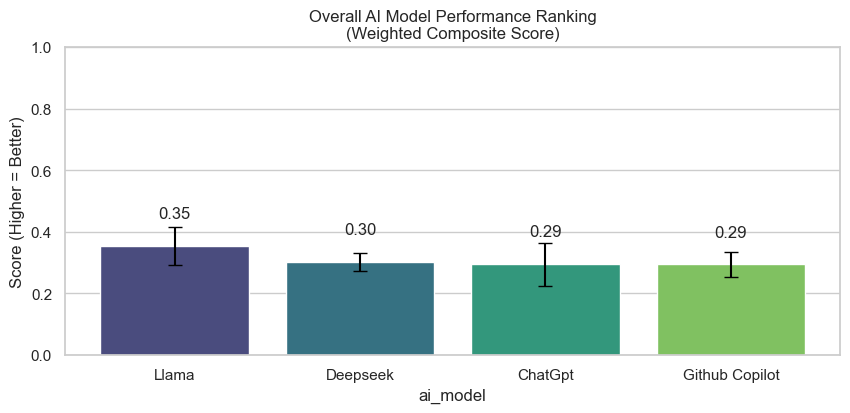

In [186]:
# Calculate composite score (weighted metric)
weights = {
    'correctnes': 0.35,
    'maintainability': 0.30,
    'loc': -0.20,  # Lower is better
    'cyclomatic': -0.15
}

# Normalize and weight metrics
normalized = df.groupby('ai_model').agg({
    'correctnes': 'mean',
    'maintainability': lambda x: (x.mean() - x.min()) / (x.max() - x.min()),
    'loc': lambda x: 1 - ((x.mean() - x.min()) / (x.max() - x.min())),
    'cyclomatic': lambda x: 1 - ((x.mean() - x.min()) / (x.max() - x.min()))
})

# Calculate final scores
normalized['score'] = sum(normalized[col]*weight for col, weight in weights.items())
ranked = normalized.sort_values('score', ascending=False)

# Visualization
plt.figure(figsize=(10,4))
sns.barplot(x=ranked.index, y=ranked['score'], palette="viridis")
plt.title('Overall AI Model Performance Ranking\n(Weighted Composite Score)')
plt.ylabel('Score (Higher = Better)')
plt.ylim(0,1)
for i, v in enumerate(ranked['score']):
    plt.text(i, v+0.09, f"{v:.2f}", ha='center')

# Add variability (error bars) to highlight consistency:
plt.errorbar(x=ranked.index, y=ranked['score'], 
             yerr=df.groupby('ai_model')['composite_score'].std(),
             fmt='none', color='black', capsize=5)
plt.savefig('overall_ai_model_performance_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

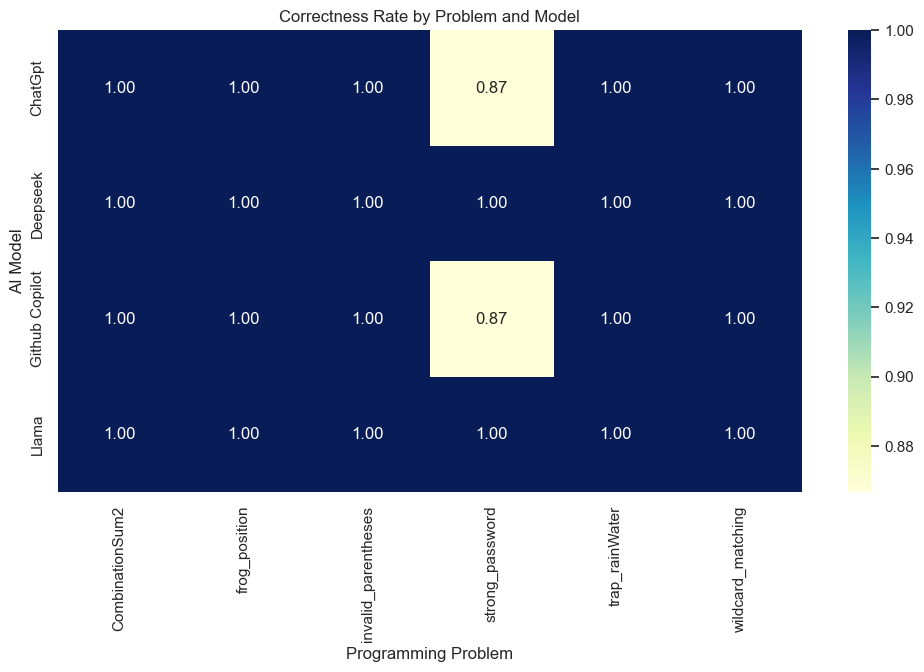

In [187]:
# Calculate problem-specific rankings
problem_rankings = df.groupby(['problems','ai_model'])['correctnes'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(problem_rankings.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correctness Rate by Problem and Model')
plt.ylabel('AI Model')
plt.xlabel('Programming Problem')
plt.savefig('correctness_rate_by_problem.png', dpi=300, bbox_inches='tight')
plt.show()

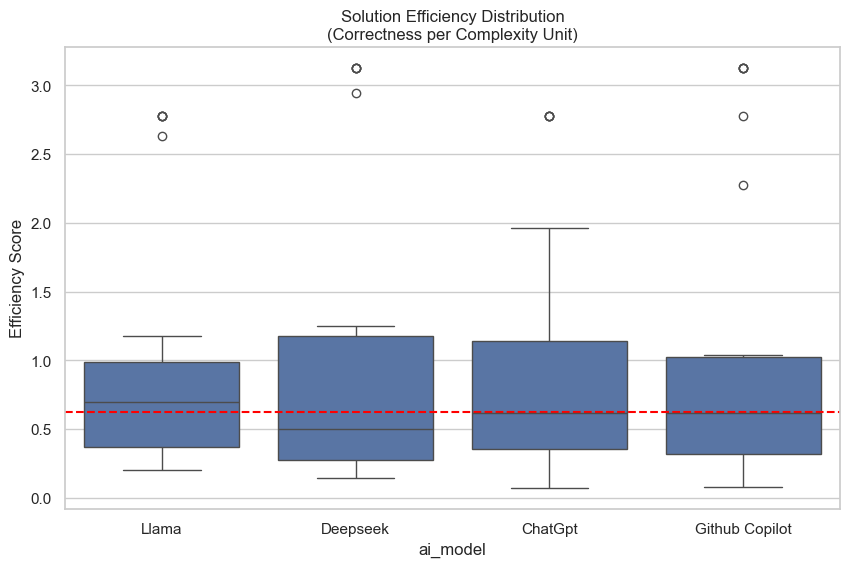

In [188]:
# Efficiency Analysis
# Calculate efficiency metrics
df['efficiency'] = (df['correctnes']*100) / (df['loc'] * df['cyclomatic'])

plt.figure(figsize=(10,6))
sns.boxplot(x='ai_model', y='efficiency', data=df, order=ranked.index)
plt.title('Solution Efficiency Distribution\n(Correctness per Complexity Unit)')
plt.ylabel('Efficiency Score')
plt.axhline(df['efficiency'].median(), color='red', linestyle='--')
plt.savefig('solution_efficiency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\rgont\AppData\Local\Temp\ipykernel_35404\1754865411.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


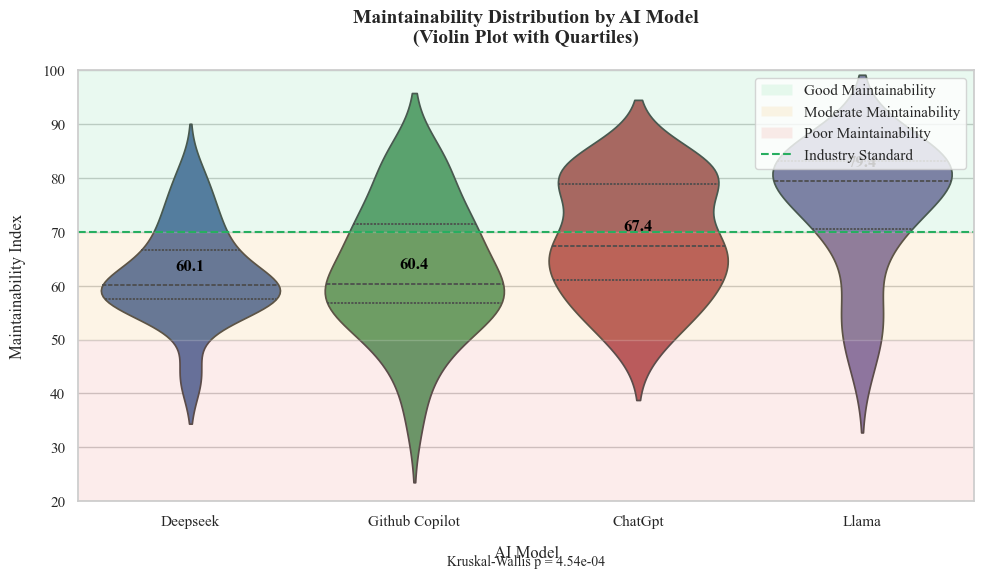

In [189]:
# Set professional style
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'

# Create enhanced visualization
plt.figure(figsize=(10, 6))

# Create violin plot
ax = sns.violinplot(
    x='ai_model',
    y='maintainability',
    data=df,
    order=['Deepseek', 'Github Copilot', 'ChatGpt', 'Llama'],  # Ranked order
    palette=['#4c72b0', '#55a868', '#c44e52', '#8172b2'],  # Colorblind-friendly
    inner='quartile'  # Show quartile lines
    # cut=0,             # Don't trim tails
    # bw=0.2             # Smoothing factor
)

# Add annotations
for i, model in enumerate(['Deepseek', 'Github Copilot', 'ChatGpt', 'Llama']):
    median = df[df['ai_model']==model]['maintainability'].median()
    ax.text(i, median+2, f'{median:.1f}',
            ha='center', va='bottom', fontweight='bold', color='black')

# Reference lines and zones
plt.axhspan(70, 100, facecolor='#2ecc71', alpha=0.1, label='Good Maintainability')
plt.axhspan(50, 70, facecolor='#f39c12', alpha=0.1, label='Moderate Maintainability')
plt.axhspan(0, 50, facecolor='#e74c3c', alpha=0.1, label='Poor Maintainability')
plt.axhline(70, color='#27ae60', linestyle='--', linewidth=1.5, label='Industry Standard')

# Formatting
plt.title('Maintainability Distribution by AI Model\n(Violin Plot with Quartiles)',
          pad=20, fontsize=14, fontweight='bold')
plt.xlabel('AI Model', labelpad=12)
plt.ylabel('Maintainability Index', labelpad=12)
plt.ylim(20, 100)
plt.legend(loc='upper right', frameon=True)

# Statistical annotation
plt.text(0.5, -0.15,
         f"Kruskal-Wallis p = {stats.kruskal(*[df[df['ai_model']==m]['maintainability'] for m in df['ai_model'].unique()])[1]:.2e}",
         transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('maintainability_comparison.png', dpi=300, bbox_inches='tight')
plt.show()